In [1]:
import sqlite3
import logging
import pandas as pd
from urllib.parse import urlparse
from tld import get_tld, get_fld
from matplotlib import pyplot as plt


In [2]:
# Specify your local path to the sqlite db containing crawl data
SQLITE_LOCAL_PATH = '/Users/liam/dev/OpenWPM/data/gemeente_social_complete.sqlite'
SM_FLDS = ['facebook', 'instagram', 'linkedin', 'google', 'youtube', 'twitter']

In [3]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(SQLITE_LOCAL_PATH)

cursor = con.cursor()

# Parse javascript table from SQLite
javascript = pd.read_sql_query("SELECT * from javascript", con)
# Parse SITE_VISITS table from SQLite
site_visits = pd.read_sql_query("SELECT * from site_visits", con)

In [4]:
# Get a sense for columns
print(javascript.columns)
print(site_visits.columns)

#Does this add up...
#print(site_visits.count())

#Drop what we don't need

javascript = javascript.drop(["id", "incognito", "crawl_id", "extension_session_uuid", "tab_id", "window_id"], axis=1)

# Let's start by looking only at the visits to the parent urls (i.e. the gemeente sites themselves)
gemeente_site_visits = site_visits.loc[site_visits['parent_url'] == site_visits['site_url']]
#print(gemeente_site_visits.count())

# Now narrow down the javascript dataframe to only visit_ids from parent_urls, and let's join the visit_url to the javascript
gemeente_visit_ids = gemeente_site_visits['visit_id']

gemeente_javascript = javascript.loc[javascript['visit_id'].isin(gemeente_visit_ids)]
#print(gemeente_javascript.count())

# Join the site_visits information into the javascript for a complete dataset and we can select columns next
all_columns = gemeente_javascript.set_index('visit_id').join(gemeente_site_visits.set_index('visit_id'), lsuffix='_javascript', rsuffix='_site_visits')

# This should be equal to javascript.columns + site_vists.columns anything that was identical now has suffixes
all_columns.columns

Index(['id', 'incognito', 'crawl_id', 'visit_id', 'extension_session_uuid',
       'event_ordinal', 'page_scoped_event_ordinal', 'window_id', 'tab_id',
       'frame_id', 'script_url', 'script_line', 'script_col', 'func_name',
       'script_loc_eval', 'document_url', 'top_level_url', 'call_stack',
       'symbol', 'operation', 'value', 'arguments', 'time_stamp'],
      dtype='object')
Index(['visit_id', 'crawl_id', 'site_url', 'parent_url'], dtype='object')


Index(['event_ordinal', 'page_scoped_event_ordinal', 'frame_id', 'script_url',
       'script_line', 'script_col', 'func_name', 'script_loc_eval',
       'document_url', 'top_level_url', 'call_stack', 'symbol', 'operation',
       'value', 'arguments', 'time_stamp', 'crawl_id', 'site_url',
       'parent_url'],
      dtype='object')

In [5]:
# What is of any interest here?
all_columns.head()

,event_ordinal,page_scoped_event_ordinal,frame_id,script_url,script_line,script_col,func_name,script_loc_eval,document_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,crawl_id,site_url,parent_url
visit_id,,,,,,,,,,,,,,,,,,,
6,138,0,0,https://gemeente.groningen.nl/misc/drupal.js?p...,575,1,,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,139,1,0,https://www.kcmsurvey.com/custom/gemeentegroni...,22,43,,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.localStorage,get,{},None,2019-05-15T21:49:02.824Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,140,2,0,https://www.kcmsurvey.com/custom/gemeentegroni...,22,63,,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.Storage.setItem,call,,"[""kcm_test"",""kcm_test""]",2019-05-15T21:49:02.906Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,141,3,0,https://www.kcmsurvey.com/custom/gemeentegroni...,22,94,,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.localStorage,get,"{""kcm_test"":""kcm_test""}",None,2019-05-15T21:49:02.907Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,142,4,0,https://www.kcmsurvey.com/custom/gemeentegroni...,22,114,,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.Storage.removeItem,call,,"[""kcm_test""]",2019-05-15T21:49:02.908Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl


In [6]:
# We didn't have this enabled... we'll see what we can get from just javascript table... 
# Cookie Access (Experimental -- Needs tests)
#     Set browser_params['cookie_instrument'] = True
#     Data is saved to the javascript_cookies table.
#     Will record cookies set both by Javascript and via HTTP Responses

javascript_analysis_set = all_columns[['func_name', "script_url", "top_level_url", "call_stack", "symbol", "operation", "value", "arguments", "time_stamp", "site_url", "parent_url"]]
javascript_analysis_set.head()
                                      

,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url
visit_id,,,,,,,,,,,
6,,https://gemeente.groningen.nl/misc/drupal.js?p...,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.localStorage,get,{},None,2019-05-15T21:49:02.824Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.Storage.setItem,call,,"[""kcm_test"",""kcm_test""]",2019-05-15T21:49:02.906Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.localStorage,get,"{""kcm_test"":""kcm_test""}",None,2019-05-15T21:49:02.907Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.Storage.removeItem,call,,"[""kcm_test""]",2019-05-15T21:49:02.908Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl


In [7]:
# What type of JS actions are happening on the top level gemeente_pages
# We are looking for cookie.get
# https://github.com/mercator-working-group/gemeente-social/issues/3

print(javascript_analysis_set.shape)

# Let's reduce to three columns, group by javascript symbol and operation, count and sort ascending...
# This will tell us the frequency of various javascript actions 
javascript_analysis_set[ ['symbol', 'operation', 'parent_url']]\
    .groupby(['symbol', 'operation'])\
    .count()\
    .sort_values(by=['parent_url'], ascending=False)\
    .head(10)

# So about ~7k of 19k javascript events are window.document.cookie 'get'
# So about ~1.6k of 19k javascript events are window.document.cookie 'set'


(19225, 11)


,,parent_url
symbol,operation,
window.document.cookie,get,6961
window.navigator.userAgent,get,4552
window.document.cookie,set,1668
window.document.referrer,get,1520
window.navigator.platform,get,727
window.navigator.vendor,get,621
window.name,get,559
window.navigator.cookieEnabled,get,518
window.localStorage,get,421


count                                19225
unique                                 335
top       https://www.midden-groningen.nl/
freq                                   205
Name: top_level_url, dtype: object


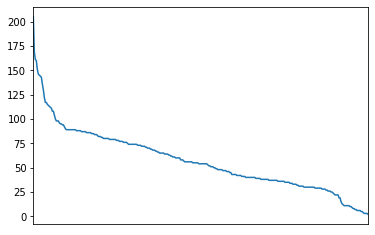

In [37]:
print(javascript_analysis_set['top_level_url'].describe())

plot = javascript_analysis_set.copy()['top_level_url'].value_counts().plot.line()
plot.axes.get_xaxis().set_visible(False)
plt.show()

In [ ]:
document_cookie = javascript_analysis_set[javascript_analysis_set['symbol'] == 'window.document.cookie']
document_cookie.shape

# Helper function to get TLD+1 level of crawled link.
def parse_tld_url(url):
    return get_fld(url, fail_silently=True)

# Create a copy to the warning goes away
script_url_cookies = document_cookie.copy()

script_url_cookies['script_url_tld'] = script_url_cookies['script_url'].apply(parse_tld_url)


def top_script_url_tld(script_url_cookies):
    # Let's create a new column with the script_url stripped to top level domain
    return script_url_cookies.copy()[['script_url_tld', 'parent_url']]\
        .groupby('script_url_tld')\
        .count()\
        .sort_values(by=['parent_url'], ascending=False)\
#         .head(20)
    
script_url_cookies.columns
# top_script_url_tld(script_url_cookies)
# Ok so we've got an idea of who is most prevelant in their cookie actions... 

In [ ]:
# For the get cookies
get_cookies = script_url_cookies.copy()
get_cookies = get_cookies[get_cookies['operation'] == 'get']
get_group = top_script_url_tld(get_cookies)

set_cookies = script_url_cookies.copy()
set_cookies = set_cookies[set_cookies['operation'] == 'set']
set_group = top_script_url_tld(set_cookies)

set_and_get = get_group.join(set_group, lsuffix='_set', rsuffix='_get')
set_and_get['total'] = set_and_get['parent_url_set'] + set_and_get['parent_url_get']
set_and_get = set_and_get.rename(index=str, columns={"parent_url_set": "window.set.cookie", "parent_url_get": "window.get.cookie"})
set_and_get.sort_values(by='total', ascending=False).head(50)


In [38]:
social_sites_document_cookie = script_url_cookies[script_url_cookies['script_url_tld'] == "facebook.net"]
pd.set_option('display.max_colwidth', 100)
social_sites_document_cookie['call_stack']

NameError: name 'script_url_cookies' is not defined